In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [3]:
class KMeans:
    """
    KMeans算法实现类

    参数:
        clusters_num(int): 聚类中心数
        times (int): 梯度下降迭代次数，默认1000
        init_method(str): 初始化方法（提供随机初始化和KMeans++）
        random_seed(int): 随机种子
    """
    def __init__(self, clusters_num, times=1000, init_method='random', random_seed=42):
        self.clusters_num = clusters_num
        self.times = times
        self.init_method = init_method
        self.centroids = None
        self.idx = None
        np.random.seed(random_seed)
    def init_random(self, X):
        """
        随机选点初始化聚类中心

        参数：
            X(np.array): 特征
        """
        n_data = X.shape[0]
        r_idx = np.random.randint(0, n_data, self.clusters_num)
        for i in range(self.clusters_num):
            self.centroids[i, :] = X[r_idx[i], :]

    def init_kmeans_pp(self, X):
        """
        KMeans++初始化聚类中心

        参数：
            X(np.array): 特征
        """
        n_samples = X.shape[0]
        # 随机分配第一个聚类中心
        first_center_idx = np.random.randint(n_samples)
        self.centroids[0] = X[first_center_idx]
        # 循环分配距离最远的聚类中心
        for i in range(1, self.clusters_num):
            distances = self.distance(X)[:, :i]
            min_distances = np.min(distances, axis=1)
            # 将距离设置成概率（越远概率越大）
            probs = min_distances / min_distances.sum()
            new_center_idx = np.random.choice(n_samples, p=probs)
            self.centroids[i] = X[new_center_idx]

    def distance(self, X):
        """
        计算特征和聚类中心距离

        参数：
            X(np.array): 特征

        返回：
            np.array: 距离
        """
        n_samples = X.shape[0]
        distances = np.zeros((n_samples, self.clusters_num))
        for i in range(self.clusters_num):
            distances[:, i] = np.sqrt(np.sum((X - self.centroids[i]) ** 2, axis=1))
        return distances

    def update_centroids(self, X, idx):
        """
        更新聚类中心

        参数：
            X(np.array): 特征
            idx(np.array): 特征分配到的聚类中心索引
        """
        for i in range(self.clusters_num):
            cluster_points = X[idx == i]
            if len(cluster_points) > 0:
                self.centroids[i] = np.mean(cluster_points, axis=0)


    def fit(self, X):
        """
        模型训练

        参数:
            X(np.array): 特征
        """
        n_samples, n_features = X.shape
        self.centroids = np.zeros((self.clusters_num, n_features))
        # 初始化
        if self.init_method == 'kmeans_pp':
            self.init_kmeans_pp(X)
        elif self.init_method == 'random':
            self.init_random(X)

        # 迭代更新聚类中心
        for i in range(self.times):
            distances = self.distance(X)
            new_idx = np.argmin(distances, axis=1)
            if self.idx is not None and np.all(new_idx == self.idx):
                # 若聚类索引不再更新，则结束迭代
                break
            self.idx = new_idx
            self.update_centroids(X, self.idx)

    def predict(self, X):
        """
        预测

        参数：
            X(np.array): 特征

        返回：
            聚类中心标签
        """
        distances = self.distance(X)
        return np.argmin(distances, axis=1)

    def evaluate(self, X, y):
        """
        模型准确率计算

        参数：
            X(np.array): 特征
            y(np.array): 真实值

        返回：
            array：准确率
        """
        # 准确率计算
        pred_idx = self.predict(X) #获得预测标签
        label_map = {'setosa': 0, 'versicolor': 1, 'virginica': 2} # 标签转换
        true_labels = np.array([label_map[label] for label in y.flatten()])

        acc = 0
        for i in [[0, 1, 2], [0, 2, 1], [1, 0, 2], [1, 2, 0], [2, 0, 1], [2, 1, 0]]:
            # 找到对应标签（KMeans标签随机分配，需要找到使准确率最大的标签对应关系）
            labels = np.zeros_like(pred_idx)
            for j, p in enumerate(i):
                labels[pred_idx == j] = p
            acc1 = np.sum(labels == true_labels) / len(true_labels)
            acc = max(acc, acc1)
        return acc

In [4]:
def split_train_test(data, train_rate=0.7, test_rate=0.3, random_seed=42):
    """
    将数据集划分为训练集、测试集

    参数：
        data (DataFrame): 要划分的数据集
        train_rate (float): 训练集比例，默认0.7
        test_rate (float): 测试集比例，默认0.3
        random_seed (int): 随机种子，默认42

    返回：
         DataFrame: 训练集，预测集
    """
    random.seed(random_seed)

    idx = list(data.index)
    random.shuffle(idx)

    train_len = int(len(data) * train_rate)
    test_len = int(len(data) * test_rate)

    # 划分数据集
    data_train = data.loc[idx[:train_len]]
    data_test = data.loc[idx[train_len:train_len + test_len]]

    return data_train, data_test

In [5]:
# 中文和负号显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [6]:
# 导入数据并分析
data = pd.read_csv("iris.csv")
print(f"数据规模：{data.shape}")
print(f"数据列名: {data.columns.tolist()}")
print(f"基础信息：\n{data.info}\n")
print(f"查看缺失：\n{data.isnull().sum()}\n")

数据规模：(150, 6)
数据列名: ['Unnamed: 0', 'Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width', 'Species']
基础信息：
<bound method DataFrame.info of      Unnamed: 0  Sepal.Length  Sepal.Width  Petal.Length  Petal.Width  \
0             1           5.1          3.5           1.4          0.2   
1             2           4.9          3.0           1.4          0.2   
2             3           4.7          3.2           1.3          0.2   
3             4           4.6          3.1           1.5          0.2   
4             5           5.0          3.6           1.4          0.2   
..          ...           ...          ...           ...          ...   
145         146           6.7          3.0           5.2          2.3   
146         147           6.3          2.5           5.0          1.9   
147         148           6.5          3.0           5.2          2.0   
148         149           6.2          3.4           5.4          2.3   
149         150           5.9          3.0         

In [7]:
# 数据划分
cols = data.shape[1]
train_data, test_data = split_train_test(data)


In [8]:
# 训练集
X_train = train_data.iloc[:,:-1]
X_train = np.array(X_train.values)
y_train = train_data.iloc[:,cols-1:cols]
y_train = np.array(y_train.values)


In [9]:
# 测试集
X_test = test_data.iloc[:,:-1]
X_test = np.array(X_test.values)
y_test = test_data.iloc[:,cols-1:cols]
y_test = np.array(y_test.values)


In [10]:
# 准确率列表初始化
acc_test1 = []
acc_test2 = []
acc_train1 = []
acc_train2 = []

In [11]:
# 对训练集准确率（用训练集训练模型）
for seed in range(51):
    # 随机初始化
    model_random = KMeans(3, 10000, 'random', seed)
    model_random.fit(X_train)
    acc = model_random.evaluate(X_train, y_train)
    acc_train1.append(acc)
    # KMeans++对比
    model_kpp = KMeans(3, 10000, 'kmeans_pp', seed)
    model_kpp.fit(X_train)
    acc = model_kpp.evaluate(X_train, y_train)
    acc_train2.append(acc)
    

In [12]:
# 对测试集准确率（用训练集训练模型）
for seed in range(51):
    # 随机初始化
    model_random = KMeans(3, 10000, 'random', seed)
    model_random.fit(X_train)
    acc = model_random.evaluate(X_test, y_test)
    acc_test1.append(acc)
    # KMeans++对比
    model_kpp = KMeans(3, 10000, 'kmeans_pp', seed)
    model_kpp.fit(X_train)
    acc = model_kpp.evaluate(X_test, y_test)
    acc_test2.append(acc)
    

In [13]:
# 打印准确率
print("训练集-随机初始化:", np.array(acc_train1))
print("训练集-KMeans++:", np.array(acc_train2))
print("测试集-随机初始化:", np.array(acc_test1))
print("测试集-KMeans++:", np.array(acc_test2))


训练集-随机初始化: [0.93333333 0.94285714 0.94285714 0.93333333 0.94285714 0.94285714
 0.94285714 0.93333333 0.94285714 0.94285714 0.94285714 0.93333333
 0.93333333 0.94285714 0.94285714 0.94285714 0.93333333 0.94285714
 0.94285714 0.93333333 0.94285714 0.94285714 0.94285714 0.93333333
 0.93333333 0.94285714 0.94285714 0.94285714 0.93333333 0.93333333
 0.93333333 0.93333333 0.94285714 0.94285714 0.93333333 0.94285714
 0.93333333 0.94285714 0.93333333 0.94285714 0.94285714 0.94285714
 0.94285714 0.94285714 0.93333333 0.93333333 0.94285714 0.93333333
 0.93333333 0.93333333 0.93333333]
训练集-KMeans++: [0.93333333 0.93333333 0.94285714 0.94285714 0.94285714 0.94285714
 0.93333333 0.93333333 0.94285714 0.93333333 0.93333333 0.94285714
 0.93333333 0.93333333 0.94285714 0.94285714 0.94285714 0.94285714
 0.94285714 0.93333333 0.94285714 0.94285714 0.93333333 0.93333333
 0.94285714 0.94285714 0.93333333 0.93333333 0.94285714 0.93333333
 0.93333333 0.94285714 0.94285714 0.93333333 0.93333333 0.94285714
 0

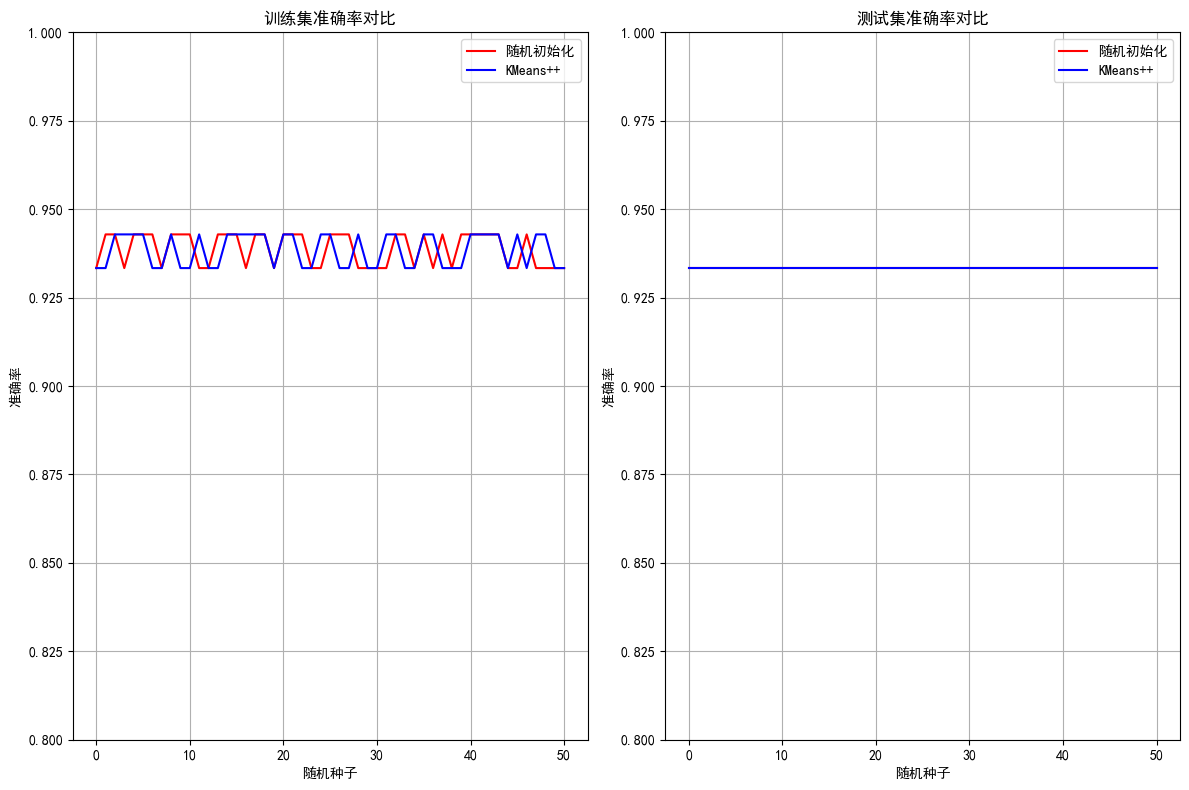

In [14]:
# 可视化
plt.figure(figsize=(12, 8))
# 训练集准确率对比折线图
plt.subplot(1, 2, 1)
plt.plot(range(51), acc_train1, 'r-', label='随机初始化')
plt.plot(range(51), acc_train2, 'b-', label='KMeans++')
plt.title('训练集准确率对比')
plt.xlabel('随机种子')
plt.ylabel('准确率')
plt.ylim(0.8, 1.0)
plt.legend()
plt.grid(True)

# 测试集准确率对比折线图
plt.subplot(1, 2, 2)
plt.plot(range(51), acc_test1, 'r-', label='随机初始化')
plt.plot(range(51), acc_test2, 'b-', label='KMeans++')
plt.title('测试集准确率对比')
plt.xlabel('随机种子')
plt.ylabel('准确率')
plt.ylim(0.8, 1.0)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
